In [2]:
import requests
from requests.auth import HTTPBasicAuth
import astropy.table as at
import matplotlib
from matplotlib.transforms import Bbox
from matplotlib.backends.backend_pdf import PdfPages
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
import astropy.units as u
from astropy.visualization import PercentileInterval, AsinhStretch
from astroquery.mast import Catalogs
from astroquery.sdss import SDSS
from astroquery.simbad import Simbad

from imblearn.over_sampling import SMOTE

import optax
import jax.numpy as jnp
import pzflow
from pzflow import Flow
from pzflow.bijectors import Chain, ShiftBounds, RollingSplineCoupling
from pzflow.distributions import Uniform

# TODO: SPLIT INTO "TRAINING" AND "TESTING"!!!
from sklearn.model_selection import train_test_split

from PIL import Image
import os
import sys
import shutil
import glob
import json

import math

import warnings
warnings.filterwarnings("ignore")


import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA

from alerce.core import Alerce
alerce = Alerce()

import antares_client

plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp

In [3]:
# From 106 available features from Kostya's lc_feature_extractor, use the 82 from SNAD Miner paper 
# R and g bands
feature_names_r_g = ['feature_amplitude_magn_r', 
                         'feature_anderson_darling_normal_magn_r',
                         'feature_beyond_1_std_magn_r', 
                         'feature_beyond_2_std_magn_r',
                         'feature_cusum_magn_r', 
                         #'feature_eta_e_magn_r',
                         'feature_inter_percentile_range_2_magn_r',
                         'feature_inter_percentile_range_10_magn_r',
                         'feature_inter_percentile_range_25_magn_r', 
                         'feature_kurtosis_magn_r',
                         'feature_linear_fit_slope_magn_r',
                         'feature_linear_fit_slope_sigma_magn_r',
                         #'feature_linear_fit_reduced_chi2_magn_r', 
                         #'feature_linear_trend_magn_r', # cadence removal
                         #'feature_linear_trend_sigma_magn_r',  # cadence removal
                         'feature_magnitude_percentage_ratio_40_5_magn_r',
                         'feature_magnitude_percentage_ratio_20_5_magn_r',
                         #'feature_maximum_slope_magn_r',
                         'feature_mean_magn_r',
                         'feature_median_absolute_deviation_magn_r',
                         'feature_percent_amplitude_magn_r',
                         'feature_median_buffer_range_percentage_10_magn_r',
                         'feature_median_buffer_range_percentage_20_magn_r',
                         'feature_percent_difference_magnitude_percentile_5_magn_r',
                         'feature_percent_difference_magnitude_percentile_10_magn_r',
                         #'feature_period_0_magn_r',  # should be negated
                         #'feature_period_s_to_n_0_magn_r', # cadence removal
                         #'feature_period_1_magn_r', 
                         #'feature_period_s_to_n_1_magn_r', # cadence removal
                         #'feature_period_2_magn_r', 
                         #'feature_period_s_to_n_2_magn_r', # cadence removal
                         #'feature_period_3_magn_r', 
                         #'feature_period_s_to_n_3_magn_r', # cadence removal
                         #'feature_period_4_magn_r', 
                         #'feature_period_s_to_n_4_magn_r', # cadence removal
                         #'feature_periodogram_amplitude_magn_r',
                         #'feature_periodogram_beyond_2_std_magn_r',  # cadence removal
                         #'feature_periodogram_beyond_3_std_magn_r',  # cadence removal
                         #'feature_periodogram_standard_deviation_magn_r',   # cadence removal
                         #'feature_chi2_magn_r',
                         'feature_skew_magn_r', 
                         'feature_standard_deviation_magn_r',
                         'feature_stetson_k_magn_r',
                         'feature_weighted_mean_magn_r',
                         'feature_anderson_darling_normal_flux_r', 
                         'feature_cusum_flux_r',
                         #'feature_eta_e_flux_r', 
                         'feature_excess_variance_flux_r',
                         'feature_kurtosis_flux_r', 
                         'feature_mean_variance_flux_r',
                         #'feature_chi2_flux_r', 
                         'feature_skew_flux_r',
                         'feature_stetson_k_flux_r',

                         'feature_amplitude_magn_g', 
                         'feature_anderson_darling_normal_magn_g',
                         'feature_beyond_1_std_magn_g', 
                         'feature_beyond_2_std_magn_g',
                         'feature_cusum_magn_g', 
                         #'feature_eta_e_magn_g',
                         'feature_inter_percentile_range_2_magn_g',
                         'feature_inter_percentile_range_10_magn_g',
                         'feature_inter_percentile_range_25_magn_g', 
                         'feature_kurtosis_magn_g',
                         'feature_linear_fit_slope_magn_g',
                         'feature_linear_fit_slope_sigma_magn_g',
                         #'feature_linear_fit_reduced_chi2_magn_g', 
                         #'feature_linear_trend_magn_g', # cadence removal
                         #'feature_linear_trend_sigma_magn_g',  # cadence removal
                         'feature_magnitude_percentage_ratio_40_5_magn_g',
                         'feature_magnitude_percentage_ratio_20_5_magn_g',
                         #'feature_maximum_slope_magn_g', 
                         'feature_mean_magn_g',
                         'feature_median_absolute_deviation_magn_g',
                         'feature_median_buffer_range_percentage_10_magn_g',
                         'feature_median_buffer_range_percentage_20_magn_g',
                         'feature_percent_amplitude_magn_g',
                         'feature_percent_difference_magnitude_percentile_5_magn_g',
                         'feature_percent_difference_magnitude_percentile_10_magn_g',
                         #'feature_period_0_magn_g',  # should be negated
                         #'feature_period_s_to_n_0_magn_g', # cadence removal
                         #'feature_period_1_magn_g', 
                         #'feature_period_s_to_n_1_magn_g', # cadence removal
                         #'feature_period_2_magn_g', 
                         #'feature_period_s_to_n_2_magn_g', # cadence removal
                         #'feature_period_3_magn_g', 
                         #'feature_period_s_to_n_3_magn_g', # cadence removal
                         #'feature_period_4_magn_g', 
                         #'feature_period_s_to_n_4_magn_g', # cadence removal
                         #'feature_periodogram_amplitude_magn_g',
                         #'feature_periodogram_beyond_2_std_magn_g',  # cadence removal
                         #'feature_periodogram_beyond_3_std_magn_g', # cadence removal
                         #'feature_periodogram_standard_deviation_magn_g',  # cadence removal
                         #'feature_chi2_magn_g',
                         'feature_skew_magn_g', 
                         'feature_standard_deviation_magn_g',
                         'feature_stetson_k_magn_g', 
                         'feature_weighted_mean_magn_g',
                         'feature_anderson_darling_normal_flux_g', 
                         'feature_cusum_flux_g',
                         #'feature_eta_e_flux_g', 
                         'feature_excess_variance_flux_g',
                         'feature_kurtosis_flux_g', 
                         'feature_mean_variance_flux_g',
                         #'feature_chi2_flux_g', 
                         'feature_skew_flux_g',
                         'feature_stetson_k_flux_g'] 
    
ztf_id_and_features_r_g = ['Unnamed: 0'] + ['locus_id', 'ra', 'dec',\
                            'tags', 'catalogs', 'ztf_object_id', 'ztf_ssnamenr', 'num_alerts',\
                            'num_mag_values', 'oldest_alert_id', 'oldest_alert_magnitude',\
                            'oldest_alert_observation_time', 'newest_alert_id',\
                            'newest_alert_magnitude', 'newest_alert_observation_time',\
                            'brightest_alert_id', 'brightest_alert_magnitude', \
                            'brightest_alert_observation_time'] + feature_names_r_g +\
                        ['horizons_targetname', 'anomaly', 'anom_score', 'anomaly_score',\
                         'anomaly_mask', 'anomaly_type', 'is_corrected', 'vpdf_extreme_version',\
                         'vpdf_extreme_faint', 'vpdf_extreme_bright', 'locus_gal_l', 'locus_gal_b']


feature_names_hostgal = [
#  'Unnamed: 0',
#  'level_0',
#  'index',
#  'objName',
#  'objAltName1',
#  'objAltName2',
#  'objAltName3',
#  'objID',
#  'uniquePspsOBid',
#  'ippObjID',
#  'surveyID',
#  'htmID',
#  'zoneID',
#  'tessID',
#  'projectionID',
#  'skyCellID',
#  'randomID',
#  'batchID',
#  'dvoRegionID',
#  'processingVersion',
#  'objInfoFlag',
#  'qualityFlag',
#  'raStack',
#  'decStack',
#  'raStackErr',
#  'decStackErr',
#  'raMean',
#  'decMean',
#  'raMeanErr',
#  'decMeanErr',
#  'epochMean',
#  'posMeanChisq',
#  'cx',
#  'cy',
#  'cz',
#  'lambda',
#  'beta',
#  'l',
#  'b',
#  'nStackObjectRows',
#  'nStackDetections',
#  'nDetections',
#  'ng',
#  'nr',
#  'ni',
#  'nz',
#  'ny',
#  'uniquePspsSTid',
#  'primaryDetection',
#  'bestDetection',
#  'gippDetectID',
#  'gstackDetectID',
#  'gstackImageID',
#  'gra',
#  'gdec',
#  'graErr',
#  'gdecErr',
#  'gEpoch',
#  'gPSFMag',
#  'gPSFMagErr',
#  'gApMag',
#  'gApMagErr',
#  'gKronMag',
#  'gKronMagErr',
#  'ginfoFlag',
#  'ginfoFlag2',
#  'ginfoFlag3',
#  'gnFrames',
#  'gxPos',
#  'gyPos',
#  'gxPosErr',
#  'gyPosErr',
#  'gpsfMajorFWHM',
#  'gpsfMinorFWHM',
#  'gpsfTheta',
#  'gpsfCore',
#  'gpsfLikelihood',
#  'gpsfQf',
#  'gpsfQfPerfect',
#  'gpsfChiSq',
 'gmomentXX',
 'gmomentXY',
 'gmomentYY',
 'gmomentR1',
 'gmomentRH',
 'gPSFFlux',
#  'gPSFFluxErr',
 'gApFlux',
#  'gApFluxErr',
#  'gApFillFac',
#  'gApRadius',
 'gKronFlux',
#  'gKronFluxErr',
 'gKronRad',
#  'gexpTime',
 'gExtNSigma',
#  'gsky',
#  'gskyErr',
#  'gzp',
#  'gPlateScale',
#  'rippDetectID',
#  'rstackDetectID',
#  'rstackImageID',
#  'rra',
#  'rdec',
#  'rraErr',
#  'rdecErr',
#  'rEpoch',
# 'rPSFMag',
#  'rPSFMagErr',
# 'rApMag',
#  'rApMagErr',
# 'rKronMag',
#  'rKronMagErr',
#  'rinfoFlag',
#  'rinfoFlag2',
#  'rinfoFlag3',
#  'rnFrames',
#  'rxPos',
#  'ryPos',
#  'rxPosErr',
#  'ryPosErr',
#  'rpsfMajorFWHM',
#  'rpsfMinorFWHM',
#  'rpsfTheta',
#  'rpsfCore',
#  'rpsfLikelihood',
#  'rpsfQf',
#  'rpsfQfPerfect',
#  'rpsfChiSq',
 'rmomentXX',
 'rmomentXY',
 'rmomentYY',
 'rmomentR1',
 'rmomentRH',
'rPSFFlux',
#  'rPSFFluxErr',
'rApFlux',
#  'rApFluxErr',
#  'rApFillFac',
# 'rApRadius',
'rKronFlux',
#  'rKronFluxErr',
'rKronRad',
#  'rexpTime',
 'rExtNSigma',
#  'rsky',
#  'rskyErr',
#  'rzp',
#  'rPlateScale',
#  'iippDetectID',
#  'istackDetectID',
#  'istackImageID',
#  'ira',
#  'idec',
#  'iraErr',
#  'idecErr',
#  'iEpoch',
#  'iPSFMag',
#  'iPSFMagErr',
#  'iApMag',
#  'iApMagErr',
#  'iKronMag',
#  'iKronMagErr',
#  'iinfoFlag',
#  'iinfoFlag2',
#  'iinfoFlag3',
#  'inFrames',
#  'ixPos',
#  'iyPos',
#  'ixPosErr',
#  'iyPosErr',
#  'ipsfMajorFWHM',
#  'ipsfMinorFWHM',
#  'ipsfTheta',
#  'ipsfCore',
#  'ipsfLikelihood',
#  'ipsfQf',
#  'ipsfQfPerfect',
#  'ipsfChiSq',
  'imomentXX',
 'imomentXY',
 'imomentYY',
 'imomentR1',
 'imomentRH',
 'iPSFFlux',
#  'iPSFFluxErr',
 'iApFlux',
#  'iApFluxErr',
#  'iApFillFac',
#  'iApRadius',
 'iKronFlux',
#  'iKronFluxErr',
 'iKronRad',
#  'iexpTime',
  'iExtNSigma',
#  'isky',
#  'iskyErr',
#  'izp',
#  'iPlateScale',
#  'zippDetectID',
#  'zstackDetectID',
#  'zstackImageID',
#  'zra',
#  'zdec',
#  'zraErr',
#  'zdecErr',
#  'zEpoch',
#  'zPSFMag',
#  'zPSFMagErr',
#  'zApMag',
#  'zApMagErr',
#  'zKronMag',
#  'zKronMagErr',
#  'zinfoFlag',
#  'zinfoFlag2',
#  'zinfoFlag3',
#  'znFrames',
#  'zxPos',
#  'zyPos',
#  'zxPosErr',
#  'zyPosErr',
#  'zpsfMajorFWHM',
#  'zpsfMinorFWHM',
#  'zpsfTheta',
#  'zpsfCore',
#  'zpsfLikelihood',
#  'zpsfQf',
#  'zpsfQfPerfect',
#  'zpsfChiSq',
  'zmomentXX',
 'zmomentXY',
 'zmomentYY',
 'zmomentR1',
 'zmomentRH',
 'zPSFFlux',
# #  'zPSFFluxErr',
 'zApFlux',
# #  'zApFluxErr',
# #  'zApFillFac',
# #  'zApRadius',
 'zKronFlux',
# #  'zKronFluxErr',
 'zKronRad',
# #  'zexpTime',
  'zExtNSigma',
#  'zsky',
#  'zskyErr',
#  'zzp',
#  'zPlateScale',
#  'yippDetectID',
#  'ystackDetectID',
#  'ystackImageID',
#  'yra',
#  'ydec',
#  'yraErr',
#  'ydecErr',
#  'yEpoch',
#  'yPSFMag',
#  'yPSFMagErr',
#  'yApMag',
#  'yApMagErr',
#  'yKronMag',
#  'yKronMagErr',
#  'yinfoFlag',
#  'yinfoFlag2',
#  'yinfoFlag3',
#  'ynFrames',
#  'yxPos',
#  'yyPos',
#  'yxPosErr',
#  'yyPosErr',
#  'ypsfMajorFWHM',
#  'ypsfMinorFWHM',
#  'ypsfTheta',
#  'ypsfCore',
#  'ypsfLikelihood',
#  'ypsfQf',
#  'ypsfQfPerfect',
#  'ypsfChiSq',
  'ymomentXX',
  'ymomentXY',
  'ymomentYY',
  'ymomentR1',
  'ymomentRH',
  'yPSFFlux',
# #   'yPSFFluxErr',
  'yApFlux',
# #   'yApFluxErr',
# #   'yApFillFac',
# #  'yApRadius',
 'yKronFlux',
# #  'yKronFluxErr',
 'yKronRad',
# #  'yexpTime',
  'yExtNSigma',
#  'ysky',
#  'yskyErr',
#  'yzp',
#  'yPlateScale',
#  'distance',
#  'SkyMapper_StarClass',
#  'gelong',
#  'g_a',
#  'g_b',
#  'g_pa',
#  'relong',
#  'r_a',
#  'r_b',
#  'r_pa',
#  'ielong',
#  'i_a',
#  'i_b',
#  'i_pa',
#  'zelong',
#  'z_a',
#  'z_b',
#  'z_pa',
   'i-z', # try throwing in
#    'g-r',
#    'r-i',
#    'g-i',
#    'z-y',
#   'g-rErr',
#   'r-iErr',
#   'i-zErr',
#   'z-yErr',
 'gApMag_gKronMag',
 'rApMag_rKronMag',
 'iApMag_iKronMag',
 'zApMag_zKronMag',
 'yApMag_yKronMag',
 '7DCD', 
#  'NED_name',
#  'NED_type',
#  'NED_vel',
#  'NED_redshift',
#  'NED_mag',
#  'class',
   'dist/DLR',
#   'dist',
#  'TransientClass',
#  'TransientRA',
#  'TransientDEC'
   ]

feature_names_tns = ['has_tns', 'tns_cls', 'spec_z', 'report_group']

lc_and_host_features = feature_names_r_g+feature_names_hostgal
lc_and_host_and_tns_features = lc_and_host_features + feature_names_tns


In [4]:
# Read in all prior DFs from LAISS

dataset_bank_9k = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_and_tns_df_9420objects.csv.gz', 
                           compression='gzip', index_col='ztf_object_id')
g_hosts_has_ps1_objid_df = pd.read_csv('../loci_dbs/alerce_cut/g_hosts_has_ps1_objid_df.csv.gz', 
                                       compression='gzip', index_col=0)
dataset_bank = pd.merge(dataset_bank_9k, g_hosts_has_ps1_objid_df, left_index=True, right_index=True, how='outer')
dataset_bank.index.rename("ztf_object_id", inplace=True)
dataset_bank = dataset_bank[dataset_bank.index.str.startswith('ZTF')]
dataset_bank = dataset_bank[~dataset_bank[lc_and_host_features].isnull().any(axis=1)]
# only keep features of bank
dataset_bank_orig = dataset_bank[lc_and_host_features]

dataset_bank_host_ra_dec = dataset_bank[['raMean', 'decMean']]
dataset_bank_orig_host_ra_dec = pd.concat([dataset_bank_host_ra_dec, dataset_bank_orig], axis=1)
#dataset_bank_orig_host_ra_dec.to_csv('../loci_dbs/alerce_cut/dataset_bank_orig_host_ra_dec.csv')
 
dataset_bank_transient_ra_dec = dataset_bank[['ra', 'dec']]
dataset_bank_orig_transient_ra_dec = pd.concat([dataset_bank_transient_ra_dec, dataset_bank_orig], axis=1)
#dataset_bank_orig_transient_ra_dec.to_csv('../loci_dbs/alerce_cut/dataset_bank_orig_transient_ra_dec.csv')
dataset_bank_orig_transient_ra_dec

,ra,dec,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,...,yKronRad,yExtNSigma,i-z,gApMag_gKronMag,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF17aaadars,74.008152,4.688007,2.212344,1.505980,0.230769,0.076923,0.219422,4.419900,3.036353,1.432270,...,2.28946,0.923409,0.257099,-0.120399,-0.177700,-0.116199,-0.128300,-0.208900,48.409333,0.063386
ZTF17aaahrni,80.423285,-4.186247,1.501946,0.581482,0.333333,0.000000,0.300476,3.003893,2.881442,1.473296,...,2.43505,6.442500,0.096600,0.164299,-0.071001,0.051300,-0.024000,-0.145601,22.882911,2.639232
ZTF17aaaizmo,132.155248,10.782338,1.293614,3.713755,0.203125,0.062500,0.225453,2.284934,1.438089,1.132104,...,5.85443,28.151199,0.027800,0.855101,0.652599,0.618401,0.684500,0.695499,14.803999,4.788567
ZTF17aabtbti,118.854567,23.997832,1.008719,1.058085,0.349398,0.012048,0.340949,1.579297,1.319507,0.743997,...,2.25483,3.383140,0.175501,-0.055199,0.066099,-0.006701,-0.024200,-0.064001,5.578753,11.742125
ZTF17aachsxt,57.955063,9.164834,0.855611,0.674008,0.387755,0.020408,0.226342,1.452768,1.048975,0.706010,...,3.51504,20.063499,-0.094900,0.122499,0.208000,0.324200,0.378099,0.192301,45.767392,4.255986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF22aaboeex,274.887940,68.377499,0.068989,0.268161,0.500000,0.000000,0.381361,0.137978,0.132096,0.079157,...,6.76913,26.586201,0.233500,0.784500,0.708401,0.683500,0.644199,0.548500,25.406284,1.134230
ZTF22aaboiqa,175.707709,57.542023,0.205293,0.126299,0.400000,0.000000,0.364903,0.410585,0.410585,0.253444,...,2.79864,5.512640,0.042000,-0.048300,-0.035500,-0.026699,0.067301,-0.125101,10.365118,0.148034
ZTF22aabovlw,246.305907,33.773774,0.113249,0.078036,0.500000,0.000000,0.396465,0.226498,0.226498,0.157836,...,6.67416,21.558701,0.225199,0.468000,0.606100,0.483999,0.585100,0.647001,33.811442,4.407910


In [5]:
bank_and_tns_df = pd.read_csv('../loci_dbs/alerce_cut/bank_and_tns_df.csv.gz', compression='gzip', index_col=0)
bank_and_tns_df

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF17aaahrni,1.501946,0.581482,0.333333,0.000000,0.300476,3.003893,2.881442,1.473296,-0.323815,0.000616,...,-0.071001,0.051300,-0.024000,-0.145601,22.882911,2.639232,Yes_TNS,None,-99.00,GaiaAlerts
ZTF17aadqidc,0.118791,0.276625,0.428571,0.000000,0.385504,0.237581,0.223594,0.138365,-0.817505,0.013288,...,0.163198,0.160099,0.150101,0.122200,26.155457,0.051662,No_TNS,None,-99.00,None
ZTF17aaducdh,0.384243,0.400104,0.333333,0.083333,0.379044,0.768486,0.586268,0.218094,0.425088,0.025251,...,0.223600,0.021301,0.269098,0.174500,11.297927,0.018901,Yes_TNS,None,-99.00,GaiaAlerts
ZTF18aaaokus,1.337077,4.369050,0.320225,0.005618,0.365946,2.108598,1.640040,0.837900,-0.695091,-0.001890,...,1.217501,1.251801,1.243600,1.272200,119.727409,0.005603,Yes_TNS,None,-99.00,ZTF
ZTF18aaavffc,1.251362,2.169584,0.291667,0.025000,0.338697,2.387948,2.022931,0.747013,-0.276298,-0.002842,...,0.625299,0.541301,0.607000,0.500100,87.296246,0.003534,Yes_TNS,None,-99.00,ALeRCE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF22aaboeex,0.068989,0.268161,0.500000,0.000000,0.381361,0.137978,0.132096,0.079157,-0.901772,-0.028012,...,0.708401,0.683500,0.644199,0.548500,25.406284,1.134230,Yes_TNS,SN Ia,0.09,ZTF
ZTF22aaboiqa,0.205293,0.126299,0.400000,0.000000,0.364903,0.410585,0.410585,0.253444,-1.169788,-0.029534,...,-0.035500,-0.026699,0.067301,-0.125101,10.365118,0.148034,Yes_TNS,None,-99.00,ANTARES
ZTF22aabovlw,0.113249,0.078036,0.500000,0.000000,0.396465,0.226498,0.226498,0.157836,-1.919301,0.000368,...,0.606100,0.483999,0.585100,0.647001,33.811442,4.407910,Yes_TNS,None,-99.00,ANTARES


In [6]:
Counter(bank_and_tns_df['tns_cls'])

Counter({'None': 3816,
         'TDE': 20,
         'SN Ia': 1098,
         'SN II': 243,
         'SN Ia-pec': 10,
         'SN IIn': 59,
         'SN Ia-91T-like': 37,
         'SN IIP': 14,
         'CV': 8,
         'SN': 5,
         'SLSN-I': 11,
         'SN Ib': 25,
         'SLSN-II': 14,
         'Varstar': 2,
         'SN IIb': 21,
         'SN Ic-BL': 14,
         'SN Ic': 21,
         'AGN': 7,
         'SN Ia-CSM': 4,
         'SN Iax[02cx-like]': 3,
         'Nova': 3,
         'SN Ia-91bg-like': 6,
         'SN Ib-pec': 2,
         'SN I': 6,
         'SN II-pec': 2,
         'SN Ib/c': 5,
         'Other': 5,
         'SN Ibn': 7,
         'SN Icn': 1,
         'SN IIn-pec': 1,
         'SN Ia-SC': 2})

In [7]:
# Cut classes with less than 4 occurances
                                      
# filter the DataFrame based on the occurrence count of labels in "tns_cls" column
bank_and_tns_df_cut = bank_and_tns_df.groupby('tns_cls').filter(lambda x: len(x) >= 14)
Counter(bank_and_tns_df_cut.tns_cls)

Counter({'None': 3816,
         'TDE': 20,
         'SN Ia': 1098,
         'SN II': 243,
         'SN IIn': 59,
         'SN Ia-91T-like': 37,
         'SN IIP': 14,
         'SN Ib': 25,
         'SLSN-II': 14,
         'SN IIb': 21,
         'SN Ic-BL': 14,
         'SN Ic': 21})

In [8]:
# split the data into training and testing sets
bank_and_tns_df_cut_train_df, bank_and_tns_df_cut_test_df = train_test_split(bank_and_tns_df_cut, 
                                                                             test_size=0.20, 
                                                                             random_state=10)

In [9]:
bank_and_tns_df_cut_train_df

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21abmgtat,0.121904,0.230847,0.333333,0.000000,0.261333,0.243809,0.230761,0.113331,-0.219986,0.002361,...,0.489399,0.549101,0.482800,0.428999,45.550070,0.036651,Yes_TNS,None,-99.0000,ALeRCE
ZTF18achdfqm,0.470350,0.474306,0.333333,0.000000,0.417916,0.940701,0.908838,0.707936,-1.630949,0.010391,...,0.591801,0.621698,0.693800,0.750700,4.841876,0.268249,No_TNS,None,-99.0000,None
ZTF21aagsihi,1.877941,1.139061,0.375000,0.000000,0.450437,3.729228,3.119188,2.198104,-1.478907,0.039536,...,0.743299,0.771400,0.788401,0.605900,63.663109,0.048331,Yes_TNS,SN Ia,0.0237,ATLAS
ZTF19aapswkx,0.186474,0.116516,0.500000,0.000000,0.418552,0.372948,0.372948,0.294826,-4.158978,0.002786,...,0.277401,0.336700,0.177801,0.333200,40.375798,0.051956,Yes_TNS,None,-99.0000,ZTF
ZTF20aclkhnm,0.739245,1.139875,0.166667,0.083333,0.395673,1.478491,1.095229,0.561468,1.248835,-0.021029,...,0.417900,0.077301,1.179501,1.208699,97.442370,0.329514,Yes_TNS,None,-99.0000,ZTF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20aciuuks,0.316088,0.353421,0.333333,0.000000,0.346037,0.632175,0.546621,0.289869,-0.905546,0.012960,...,0.517599,0.491701,0.567400,0.076399,31.536662,0.139680,Yes_TNS,None,-99.0000,ALeRCE
ZTF21aaydumh,0.237472,0.503993,0.384615,0.000000,0.243716,0.474943,0.407579,0.271858,-1.017295,0.001209,...,0.704800,0.551600,0.597300,0.385601,147.285516,0.413932,Yes_TNS,None,-99.0000,ALeRCE
ZTF20aconebc,0.291277,0.494884,0.166667,0.000000,0.330584,0.582554,0.544017,0.197184,2.991826,0.021715,...,0.155300,0.224300,0.152802,0.109200,20.071106,0.082607,No_TNS,None,-99.0000,None


In [10]:
Counter(bank_and_tns_df_cut_train_df.tns_cls)

Counter({'None': 3039,
         'SN Ia': 882,
         'SN II': 200,
         'SN IIb': 17,
         'SN IIn': 50,
         'SN Ic': 16,
         'SN Ic-BL': 12,
         'SN IIP': 11,
         'SLSN-II': 14,
         'SN Ia-91T-like': 31,
         'TDE': 13,
         'SN Ib': 20})

In [11]:
bank_and_tns_df_cut_train_df[bank_and_tns_df_cut_train_df.tns_cls == 'SN Ia'][lc_and_host_features].iloc[0:5, :]

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,yKronRad,yExtNSigma,i-z,gApMag_gKronMag,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21aagsihi,1.877941,1.139061,0.375000,0.0,0.450437,3.729228,3.119188,2.198104,-1.478907,0.039536,...,7.16800,23.426701,0.123600,0.565300,0.743299,0.771400,0.788401,0.605900,63.663109,0.048331
ZTF20acpqagp,0.329587,0.298307,0.428571,0.0,0.423844,0.659174,0.609722,0.382661,-1.503199,-0.001136,...,10.07410,17.188700,0.306800,0.636399,0.594600,0.729800,0.635100,0.573899,117.947571,0.253371
ZTF21aagygzv,0.346822,0.405747,0.166667,0.0,0.369700,0.693644,0.651121,0.268415,1.685339,0.033092,...,5.13925,11.079400,0.180201,0.333300,0.347799,0.388399,0.348099,0.169498,42.674832,0.682993
ZTF20actvpyc,0.903797,0.885401,0.307692,0.0,0.404724,1.807594,1.554398,0.871788,-0.322823,0.019415,...,2.17353,3.058550,-0.003201,-0.083900,-0.078899,-0.061600,-0.113100,-0.184801,8.111672,0.190701
ZTF21acizbmv,0.191737,0.614489,0.250000,0.0,0.305011,0.383474,0.293019,0.057849,2.885929,0.016709,...,2.21623,6.646900,0.088999,-0.043001,-0.029999,-0.017200,0.069201,-0.111200,9.077384,0.070834


In [12]:
class_list = list(np.unique(bank_and_tns_df_cut.tns_cls))[1:]
class_list

['SLSN-II',
 'SN II',
 'SN IIP',
 'SN IIb',
 'SN IIn',
 'SN Ia',
 'SN Ia-91T-like',
 'SN Ib',
 'SN Ic',
 'SN Ic-BL',
 'TDE']


START: 0 END: 20
SN II


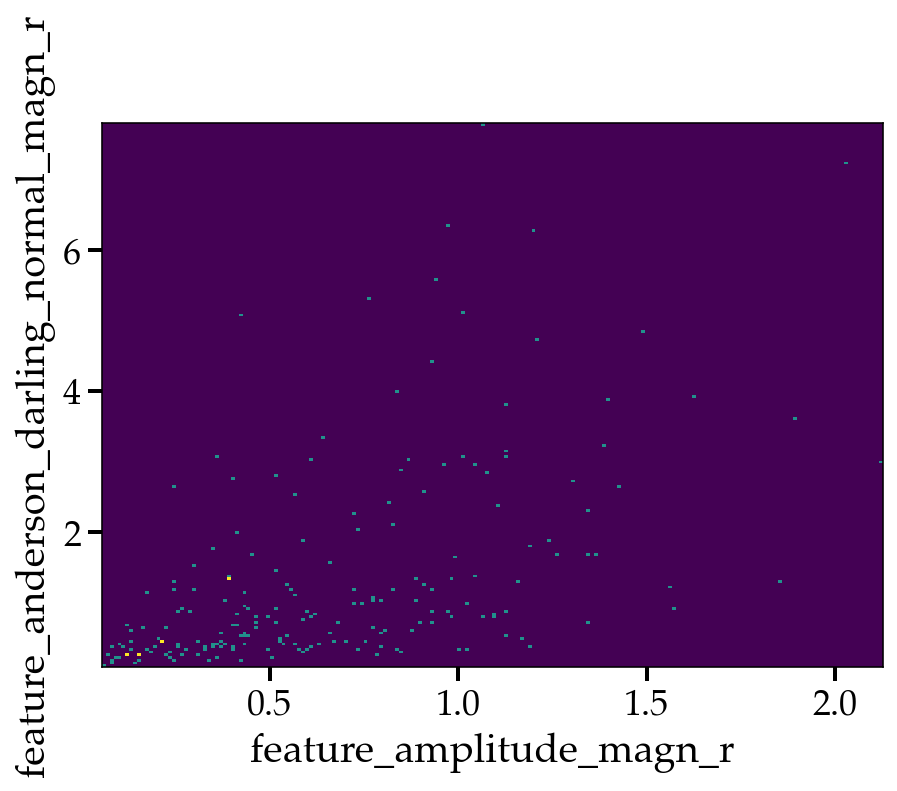

ndim 20


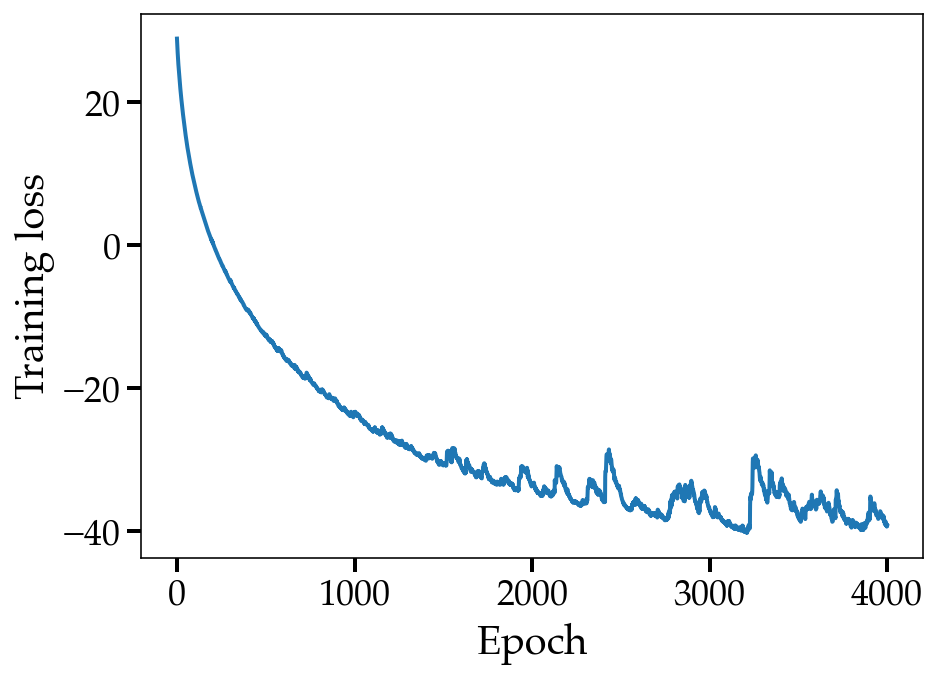

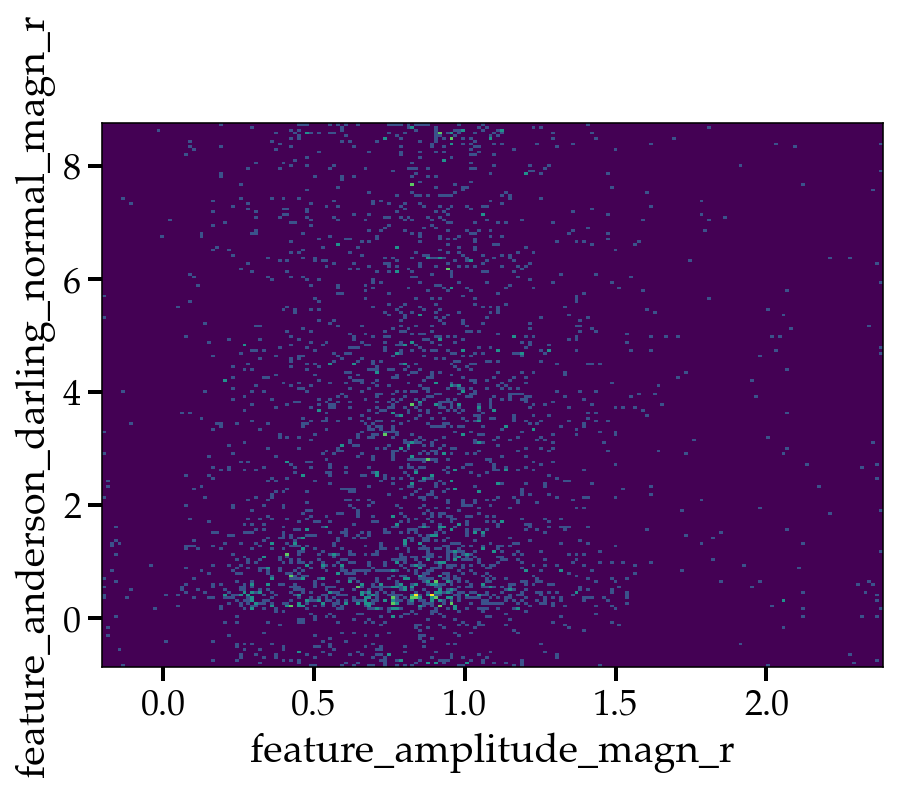

CPU times: user 13min 21s, sys: 3min 59s, total: 17min 21s
Wall time: 11min 20s


In [16]:
%%time
num=3039
n_epochs = 4000 #1500
class_list = list(np.unique(bank_and_tns_df_cut.tns_cls))[2:3] # No NONE
n_classes = len(class_list)

opt = optax.adam(1e-5) # smaller learning rate --> fewer spikes
# determine how many layers in the RollingSplineCoupling
# and how far to shift the dimension in each layer
# note you want nlayers * shift >= number of columns in data
# increasing nlayers will increase expressiveness of flow, but is more expensive
nlayers = 12 # 12
shift = 10 # 10

n_dim = 120
start_idx_l = list(np.arange(0, n_dim, n_dim)) # 120
end_idx_l = list(np.arange(n_dim, n_dim+n_dim, n_dim)) #125

fullsamples_all_dim_l = []
for start, end in zip(start_idx_l, end_idx_l):
    start_idx, end_idx = start, end
    print("\nSTART:", start, "END:", end)
    
    
    # # PZFLOW the data - even class distr
    # https://jfcrenshaw.github.io/pzflow/tutorials/customizing_example/

    df_list = []
    for SNtype in class_list:#, 'SN II', 'SN Ic']:
        print(SNtype)
        cls_df = bank_and_tns_df_cut_train_df[bank_and_tns_df_cut_train_df['tns_cls'] == SNtype][lc_and_host_features].iloc[:, start_idx:end_idx]
        #print(cls_df)
        #print("length cls_df", len(cls_df))
        
        if end_idx % 0 == 0:
            feat_x = lc_and_host_features[start_idx:end_idx][0]
            feat_y = lc_and_host_features[start_idx:end_idx][1]
            plt.hist2d(cls_df[feat_x], cls_df[feat_y], bins=200)
            plt.xlabel(feat_x)
            plt.ylabel(feat_y)
            plt.show()
        
        # get minima and maxima for each column
        mins = jnp.array(cls_df.min(axis=0))
        maxs = jnp.array(cls_df.max(axis=0))

        # get the number of dimensions
        ndim = cls_df.shape[1]
        print("ndim", ndim)

        # build the bijector
        bijector = Chain(
            ShiftBounds(mins, maxs, B=4),
            RollingSplineCoupling(ndim, B=5), #nlayers=nlayers, shift=shift, ndim, B=5
        )
        
        latent = Uniform(input_dim=ndim, B=5)
        flow = Flow(lc_and_host_features[start_idx:end_idx], bijector=bijector, latent=latent)

        losses = flow.train(cls_df, verbose=False, epochs=n_epochs, optimizer=opt)
        
        if end_idx % 0 == 0:
            plt.plot(losses)
            plt.xlabel("Epoch")
            plt.ylabel("Training loss")
            plt.show()

        samples = flow.sample(num-len(cls_df), seed=10)
        #print("length samples", len(samples))
        
        if end_idx % 0 == 0:
            plt.hist2d(samples[feat_x], samples[feat_y], bins=200)
            plt.xlabel(feat_x)
            plt.ylabel(feat_y)
            plt.show()

        if end_idx==n_dim:
            samples['tns_cls'] = SNtype
        df_list.append(samples)
    fullsamples = pd.concat(df_list)
    fullsamples_all_dim_l.append(fullsamples)
    fullsamples_all_dim_df = pd.concat(fullsamples_all_dim_l, axis=1)
    
X_resampled = fullsamples_all_dim_df.copy().iloc[:, 0:end_idx]

#keep existing ztfids, and make fake ones for upsampled
from faker import Faker
fake = Faker()
# generate a list of 100 fake strings with the pattern 'ZTFabcXXXXX'
fake_strings = ['ZTFabc' + str(fake.unique.random_int(min=0, max=99999)).zfill(5) for _ in range(len(X_resampled))]
X_resampled_index = list(fake_strings)

X_resampled['ztf_object_id'] = X_resampled_index
X_resampled = X_resampled.set_index('ztf_object_id')

y_resampled = fullsamples_all_dim_df['tns_cls']

In [ ]:
# 3 min for 10 dim, 4000 epochs for 1 class
# 11 min for 20 dim, 4000 epochs for 1 class

%%time
num=5000
n_epochs = 500
class_list = list(np.unique(bank_and_tns_df_cut.tns_cls))
n_classes = len(class_list)

n_dim = 120
start_idx_l = list(np.arange(0, n_dim, 5)) # 120
end_idx_l = list(np.arange(5, 125, 5)) #125

fullsamples_all_dim_l = []
for start, end in zip(start_idx_l, end_idx_l):
    start_idx, end_idx = start, end
    print("\nSTART:", start, "END:", end)
    
    # # PZFLOW the data - even class distr
    flow = Flow(lc_and_host_features[start_idx:end_idx])

    df_list = []
    for SNtype in class_list:#, 'SN II', 'SN Ic']:
        print(SNtype)
        cls_df = bank_and_tns_df_cut_train_df[bank_and_tns_df_cut_train_df['tns_cls'] == SNtype][lc_and_host_features].iloc[:, start_idx:end_idx]
        #print(cls_df)
        #print("length cls_df", len(cls_df))
        
        #feat_x = lc_and_host_features[start_idx:end_idx][0]
        #feat_y = lc_and_host_features[start_idx:end_idx][1]
        #plt.hist2d(cls_df[feat_x], cls_df[feat_y], bins=200)
        #plt.xlabel(feat_x)
        #plt.ylabel(feat_y)
        #plt.show()

        losses = flow.train(cls_df, verbose=False, epochs=n_epochs)

        #plt.plot(losses)
        #plt.xlabel("Epoch")
        #plt.ylabel("Training loss")
        #plt.show()

        samples = flow.sample(num-len(cls_df), seed=10)
        #print("length samples", len(samples))
        
        #plt.hist2d(samples[feat_x], samples[feat_y], bins=200)
        #plt.xlabel(feat_x)
        #plt.ylabel(feat_y)
        #plt.show()

        if end_idx==n_dim:
            samples['tns_cls'] = SNtype
        df_list.append(samples)
    fullsamples = pd.concat(df_list)
    fullsamples_all_dim_l.append(fullsamples)
    fullsamples_all_dim_df = pd.concat(fullsamples_all_dim_l, axis=1)
    
X_resampled = fullsamples_all_dim_df.copy().iloc[:, 0:end_idx]

#keep existing ztfids, and make fake ones for upsampled
from faker import Faker
fake = Faker()
# generate a list of 100 fake strings with the pattern 'ZTFabcXXXXX'
fake_strings = ['ZTFabc' + str(fake.unique.random_int(min=0, max=99999)).zfill(5) for _ in range(len(X_resampled))]
X_resampled_index = list(fake_strings)

X_resampled['ztf_object_id'] = X_resampled_index
X_resampled = X_resampled.set_index('ztf_object_id')

y_resampled = fullsamples_all_dim_df['tns_cls']

In [13]:
X_resampled

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,yKronRad,yExtNSigma,i-z,gApMag_gKronMag,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTFabc53279,0.725253,0.487670,0.169791,-0.000021,0.398612,0.949992,0.584380,0.384113,-0.558146,0.007521,...,2.536315,1.843875,0.070672,0.026250,-0.090174,-0.070355,-0.102167,-0.266003,5.060950,0.351528
ZTFabc30883,1.722350,2.809222,0.476852,-0.004052,0.482706,1.500138,1.386245,0.482048,-0.776317,-0.019548,...,4.308095,19.481598,0.210064,0.100918,0.085267,0.070976,0.269407,-0.065621,5.854886,0.588603
ZTFabc93456,1.033357,0.998994,0.145568,0.066569,0.396197,1.307856,1.046252,0.444814,-1.045077,0.007658,...,2.578092,7.681947,-0.161122,0.033752,0.065546,-0.023015,0.077067,-0.254120,13.200617,2.786091
ZTFabc14786,0.469335,2.605069,0.436701,0.040479,0.443799,3.451591,3.533046,2.884534,1.268960,0.009340,...,3.208622,11.529232,0.355998,0.012590,0.085346,0.253436,0.572072,0.410009,11.559053,12.542202
ZTFabc83242,0.850554,0.608701,0.457641,0.000311,0.392192,3.484577,1.222971,2.966175,4.350010,0.013376,...,3.477331,5.072051,0.333325,-0.050551,0.086253,0.461742,0.508323,0.413296,24.058426,0.612018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTFabc25242,0.558568,0.521487,0.287311,0.000283,0.332889,0.308418,0.402946,0.208564,-0.646576,-0.001788,...,3.654057,14.768657,0.182080,0.026719,0.102640,-0.008482,0.014159,-0.102373,8.109207,0.059225
ZTFabc77217,1.183398,0.538917,0.434974,-0.000053,0.424709,2.271087,2.159733,1.436430,-1.110252,-0.001234,...,3.816682,10.456301,0.268972,-0.032613,-0.022178,0.986405,0.995219,1.397360,118.852493,-0.011071
ZTFabc17219,1.163957,5.376339,0.589919,-0.005039,0.454292,2.725026,2.118216,0.901229,-0.796204,0.006882,...,13.200376,37.235512,0.058022,1.524714,1.503587,0.930269,1.425969,0.998611,115.825165,0.073482


In [14]:
y_resampled

0       SLSN-II
1       SLSN-II
2       SLSN-II
3       SLSN-II
4       SLSN-II
         ...   
3021        TDE
3022        TDE
3023        TDE
3024        TDE
3025        TDE
Name: tns_cls, Length: 32163, dtype: object

In [15]:
# Make dataset_bank_orig the PZFLOW resampled
pzflow_suffix = f'PZFLOW_train_test_80-20_min14_classes{n_classes}_epochs{n_epochs}_n{num}_RollingSplineCoupling_B=5'

dataset_bank_orig_train = pd.concat([bank_and_tns_df_cut_train_df.iloc[:, 0:120], X_resampled]) #X_resampled.copy()
dataset_label_orig_train = list(bank_and_tns_df_cut_train_df['tns_cls'])+ list(y_resampled) #list(y_resampled.copy())
dataset_bank_orig_train.to_csv(f'../loci_dbs/alerce_cut/dataset_bank_orig_train_{pzflow_suffix}.csv.gz', compression='gzip')
with open(f'../loci_dbs/alerce_cut/dataset_label_orig_train_{pzflow_suffix}.pkl', 'wb') as f:
    pickle.dump(dataset_label_orig_train, f)

dataset_bank_orig_test = bank_and_tns_df_cut_test_df.iloc[:, :120]
dataset_label_orig_test = bank_and_tns_df_cut_test_df['tns_cls']
dataset_bank_orig_test.to_csv(f'../loci_dbs/alerce_cut/dataset_bank_orig_test_{pzflow_suffix}.csv.gz', compression='gzip')
with open(f'../loci_dbs/alerce_cut/dataset_label_orig_test_{pzflow_suffix}.pkl', 'wb') as f:
    pickle.dump(dataset_label_orig_test, f)


len_fill_train = len(X_resampled)#-len(bank_and_tns_df_cut_train_df)
len_fill_test = len(X_resampled)#-len(bank_and_tns_df_cut_test_df)

dataset_bank_orig = pd.concat([dataset_bank_orig_train, dataset_bank_orig_test], axis=0)

# dataset_bank_tns_df
dataset_bank_tns_df_resampled_train = dataset_bank_orig_train.copy()
dataset_bank_tns_df_resampled_train['has_tns'] = list(bank_and_tns_df_cut_train_df['has_tns'])+list(['Fake']*len_fill_train)
dataset_bank_tns_df_resampled_train['tns_cls'] = dataset_label_orig_train
dataset_bank_tns_df_resampled_train['spec_z'] = list(bank_and_tns_df_cut_train_df['spec_z'])+list([-99.0]*len_fill_train)
dataset_bank_tns_df_resampled_train['report_group'] = list(bank_and_tns_df_cut_train_df['report_group'])+list(['None']*len_fill_train)

dataset_bank_tns_df_resampled_test = dataset_bank_orig_test.copy()
dataset_bank_tns_df_resampled_test['has_tns'] = list(bank_and_tns_df_cut_test_df['has_tns'])
dataset_bank_tns_df_resampled_test['tns_cls'] =  list(bank_and_tns_df_cut_test_df['tns_cls'])
dataset_bank_tns_df_resampled_test['spec_z'] = list(bank_and_tns_df_cut_test_df['spec_z'])
dataset_bank_tns_df_resampled_test['report_group'] = list(bank_and_tns_df_cut_test_df['report_group'])

dataset_bank_tns_df_resampled_train.to_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_train_{pzflow_suffix}.csv.gz', compression='gzip')
dataset_bank_tns_df_resampled_test.to_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_test_{pzflow_suffix}.csv.gz', compression='gzip')


dataset_bank_tns_df_resampled = pd.concat([dataset_bank_tns_df_resampled_train, dataset_bank_tns_df_resampled_test], axis=0)
dataset_bank_tns_df = dataset_bank_tns_df_resampled.copy()


# dataset_bank_orig_host_ra_dec_resampled
dataset_bank_orig_host_ra_dec = dataset_bank_orig_host_ra_dec[['raMean', 'decMean']]

# dataset_bank_orig_host_ra_dec_resampled_train = pd.merge(dataset_bank_orig_train, dataset_bank_orig_host_ra_dec, left_index=True, right_index=True, how='outer')
# # fill NaN values in columns "ra" and "dec" with -99
# dataset_bank_orig_host_ra_dec_resampled_train.fillna(value=-99, inplace=True)
# dataset_bank_orig_host_ra_dec_train = dataset_bank_orig_host_ra_dec_resampled_train

# dataset_bank_orig_host_ra_dec_resampled_test = pd.merge(dataset_bank_orig_test, dataset_bank_orig_host_ra_dec, left_index=True, right_index=True, how='outer')
# # fill NaN values in columns "ra" and "dec" with -99
# dataset_bank_orig_host_ra_dec_resampled_test.fillna(value=-99, inplace=True)
# dataset_bank_orig_host_ra_dec_test = dataset_bank_orig_host_ra_dec_resampled_test

# dataset_bank_orig_host_ra_dec = pd.concat([dataset_bank_orig_host_ra_dec_train, dataset_bank_orig_host_ra_dec_test], axis=0)
# dataset_bank_orig_host_ra_dec = dataset_bank_orig_host_ra_dec[~dataset_bank_orig_host_ra_dec.isnull().any(axis=1)]


# dataset_bank_orig_transient_ra_dec
dataset_bank_orig_transient_ra_dec = dataset_bank_orig_transient_ra_dec[['ra', 'dec']]

# dataset_bank_orig_transient_ra_dec_resampled_train = pd.merge(dataset_bank_orig_train, dataset_bank_orig_transient_ra_dec, left_index=True, right_index=True, how='outer')
# # fill NaN values in columns "ra" and "dec" with -99
# dataset_bank_orig_transient_ra_dec_resampled_train.fillna(value=-99, inplace=True)
# dataset_bank_orig_transient_ra_dec_train = dataset_bank_orig_transient_ra_dec_resampled_train

# dataset_bank_orig_transient_ra_dec_resampled_test = pd.merge(dataset_bank_orig_test, dataset_bank_orig_transient_ra_dec, left_index=True, right_index=True, how='outer')
# # fill NaN values in columns "ra" and "dec" with -99
# dataset_bank_orig_transient_ra_dec_resampled_test.fillna(value=-99, inplace=True)
# dataset_bank_orig_transient_ra_dec_test = dataset_bank_orig_transient_ra_dec_resampled_test

# dataset_bank_orig_transient_ra_dec = pd.concat([dataset_bank_orig_transient_ra_dec_train, dataset_bank_orig_transient_ra_dec_test], axis=0)
# dataset_bank_orig_transient_ra_dec = dataset_bank_orig_transient_ra_dec[~dataset_bank_orig_transient_ra_dec.isnull().any(axis=1)]


# # Save full dfs
dataset_bank_orig.to_csv(f'../loci_dbs/alerce_cut/dataset_bank_orig_{pzflow_suffix}.csv.gz', compression='gzip')
dataset_bank_tns_df.to_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_{pzflow_suffix}.csv.gz', compression='gzip')
dataset_bank_orig_host_ra_dec.to_csv(f'../loci_dbs/alerce_cut/dataset_bank_orig_host_ra_dec_{pzflow_suffix}.csv.gz', compression='gzip')
dataset_bank_orig_transient_ra_dec.to_csv(f'../loci_dbs/alerce_cut/dataset_bank_orig_transient_ra_dec_{pzflow_suffix}.csv.gz', compression='gzip')


# # Uncomment if I don't use SMOTE

# # dataset_bank_orig = bank_and_tns_df.iloc[:, :120]
# # dataset_label_orig = bank_and_tns_df.iloc[:, -3] #tns_cls
# # dataset_bank_tns_df = dataset_bank_tns_df
# # dataset_bank_orig_host_ra_dec = dataset_bank_orig_host_ra_dec
# # dataset_bank_orig_transient_ra_dec = dataset_bank_orig_transient_ra_dec


# dataset_bank_orig = dataset_bank_orig_train
# dataset_label_orig = dataset_label_orig_train
# # Save pickle

# with open(f'../loci_dbs/alerce_cut/dataset_label_orig_{pzflow_suffix}.pkl', 'wb') as f:
#     pickle.dump(dataset_label_orig, f)

# dataset_bank_orig

# Load PZFLOW results

In [16]:
# yes it's dataset_bank_orig_train_{pzflow_suffix}
dataset_bank_orig = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_orig_train_{pzflow_suffix}.csv.gz', compression='gzip', index_col=0)
with open(f'../loci_dbs/alerce_cut/dataset_label_orig_train_{pzflow_suffix}.pkl', 'rb') as f:
    dataset_label_orig = pickle.load(f)

In [17]:
dataset_bank_orig

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,yKronRad,yExtNSigma,i-z,gApMag_gKronMag,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21abmgtat,0.121904,0.230847,0.333333,0.000000,0.261333,0.243809,0.230761,0.113331,-0.219986,0.002361,...,7.195000,17.462900,0.292801,0.385900,0.489399,0.549101,0.482800,0.428999,45.550070,0.036651
ZTF18achdfqm,0.470350,0.474306,0.333333,0.000000,0.417916,0.940701,0.908838,0.707936,-1.630949,0.010391,...,5.895480,21.923000,0.184500,0.735800,0.591801,0.621698,0.693800,0.750700,4.841876,0.268249
ZTF21aagsihi,1.877941,1.139061,0.375000,0.000000,0.450437,3.729228,3.119188,2.198104,-1.478907,0.039536,...,7.168000,23.426701,0.123600,0.565300,0.743299,0.771400,0.788401,0.605900,63.663109,0.048331
ZTF19aapswkx,0.186474,0.116516,0.500000,0.000000,0.418552,0.372948,0.372948,0.294826,-4.158978,0.002786,...,5.892420,22.349199,0.352800,0.293299,0.277401,0.336700,0.177801,0.333200,40.375798,0.051956
ZTF20aclkhnm,0.739245,1.139875,0.166667,0.083333,0.395673,1.478491,1.095229,0.561468,1.248835,-0.021029,...,9.735750,36.002300,0.076500,0.705400,0.417900,0.077301,1.179501,1.208699,97.442370,0.329514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTFabc25242,0.558568,0.521487,0.287311,0.000283,0.332889,0.308418,0.402946,0.208564,-0.646576,-0.001788,...,3.654057,14.768657,0.182080,0.026719,0.102640,-0.008482,0.014159,-0.102373,8.109207,0.059225
ZTFabc77217,1.183398,0.538917,0.434974,-0.000053,0.424709,2.271087,2.159733,1.436430,-1.110252,-0.001234,...,3.816682,10.456301,0.268972,-0.032613,-0.022178,0.986405,0.995219,1.397360,118.852493,-0.011071
ZTFabc17219,1.163957,5.376339,0.589919,-0.005039,0.454292,2.725026,2.118216,0.901229,-0.796204,0.006882,...,13.200376,37.235512,0.058022,1.524714,1.503587,0.930269,1.425969,0.998611,115.825165,0.073482


In [18]:
dataset_label_orig

['None',
 'None',
 'SN Ia',
 'None',
 'None',
 'SN II',
 'SN Ia',
 'SN Ia',
 'None',
 'SN Ia',
 'None',
 'SN Ia',
 'None',
 'None',
 'None',
 'None',
 'SN Ia',
 'None',
 'None',
 'SN II',
 'SN Ia',
 'None',
 'None',
 'None',
 'None',
 'None',
 'SN Ia',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'SN Ia',
 'SN IIb',
 'None',
 'None',
 'SN Ia',
 'SN IIn',
 'None',
 'SN Ia',
 'None',
 'None',
 'None',
 'SN Ia',
 'None',
 'None',
 'SN Ia',
 'None',
 'SN II',
 'None',
 'SN Ia',
 'None',
 'None',
 'None',
 'SN Ia',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'SN Ia',
 'SN Ia',
 'SN Ic',
 'SN II',
 'None',
 'SN Ic-BL',
 'SN Ia',
 'None',
 'None',
 'SN Ia',
 'None',
 'None',
 'SN Ia',
 'SN Ia',
 'None',
 'None',
 'None',
 'SN II',
 'None',
 'None',
 'SN IIb',
 'None',
 'SN Ia',
 'None',
 'None',
 'SN Ia',
 'None',
 'None',
 'None',
 'SN IIP',
 'None',
 'SN Ic',
 'SN Ia',
 'SN Ia',
 'None',
 'None',
 '

In [19]:
len(dataset_label_orig)

36468

In [20]:
Counter(dataset_label_orig)

Counter({'None': 3039,
         'SN Ia': 3039,
         'SN II': 3039,
         'SN IIb': 3039,
         'SN IIn': 3039,
         'SN Ic': 3039,
         'SN Ic-BL': 3039,
         'SN IIP': 3039,
         'SLSN-II': 3039,
         'SN Ia-91T-like': 3039,
         'TDE': 3039,
         'SN Ib': 3039})